# Shopify Fall 2021 Data Science Intern Challenge
## Written by: Dexter van Leeuwen

## Question 1
### a)  Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

#### Checking Assumptions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in and show data
df = pd.read_csv("DS_W19_challenge_data.csv",index_col='order_id')
df

,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
1,53,746,224,2,cash,2017-03-13 12:36:56
2,92,925,90,1,cash,2017-03-03 17:38:52
3,44,861,144,1,cash,2017-03-14 4:23:56
4,18,935,156,1,credit_card,2017-03-26 12:43:37
5,18,883,156,1,credit_card,2017-03-01 4:35:11
...,...,...,...,...,...,...
4996,73,993,330,2,debit,2017-03-30 13:47:17
4997,48,789,234,2,cash,2017-03-16 20:36:16
4998,56,867,351,3,cash,2017-03-19 5:42:42


In [3]:
print("Verify the data is taken from a 30-day time frame:\n")
print("Most recent date:")
print(df.created_at.max())
print("Least recent date:")
print(df.created_at.min())

print("\nConfirm we know how the naive AOV was calculated (confirm we get $3145.13):")
print(round(df.order_amount.mean(),2))

Verify the data is taken from a 30-day time frame:

Most recent date:
2017-03-30 9:55:00
Least recent date:
2017-03-01 0:08:09

Confirm we know how the naive AOV was calculated (confirm we get $3145.13):
3145.13


Since we are told that each store only sells one kind of shoe, I will name the column for average item cost per order `shoe_cost` since each item is a pair of shoes and should be the same for all orders from the same store (assuming no discounts/sales occur in our timeframe).

We double check this assumption by checking if there's an instance  where orders with the same `shop_id`have different `shoe_cost`.

In [4]:
df['shoe_cost'] = df['order_amount']/df['total_items']
df['shoe_cost'].mean()

387.7428

In [5]:
cols_of_interest = ['shop_id','shoe_cost']

# get distinct shoe_costs when grouped by shop
num_dif_cost_by_store = df[cols_of_interest].drop_duplicates().groupby('shop_id').size().reset_index(name='num_different')
print(num_dif_cost_by_store)
# get shops where there is more than one distinct "shoe_cost" value across the shop's orders
print("Shops with more than one shoe_cost")
num_dif_cost_by_store[num_dif_cost_by_store['num_different'] >1]

    shop_id  num_different
0         1              1
1         2              1
2         3              1
3         4              1
4         5              1
..      ...            ...
95       96              1
96       97              1
97       98              1
98       99              1
99      100              1

[100 rows x 2 columns]
Shops with more than one shoe_cost


,shop_id,num_different


The above dataframe is empty, so that confirms orders have the same cost per item for each shop, we can trust what was said in the question - that $\textit{"each of these shops sells only one model of shoe."}$

Next, we look at:
* the average number of items per order 
* `shoe_cost` for each store

to see if there are any anomalies - the average shoe cost (not AOV, but cost per pair of shoes) seemed quite high compared to what we saw when we showed the dataframe in the second code block. It also never hurts to do a quick check to make sure the data makes sense.

#### Checking for Anomalies

In [6]:
# get average total_items in order by shop
df.groupby('shop_id')['total_items'].mean().sort_values(ascending=False)

shop_id
42    667.901961
37      2.395833
24      2.290909
90      2.265306
10      2.245283
         ...    
25      1.791667
47      1.787234
12      1.754717
99      1.740741
16      1.731707
Name: total_items, Length: 100, dtype: float64

Besides for shop 42, we see the average quantity of items is between 1.7 and 2.4. Shop 42 has an average order $\textit{hundreds of times larger}$ than all other shops. This raises some questions as to whether this shop should be considered a "sneaker shop" like the rest of the shops - it sounds more like a bulk retailer that can handle such massive orders. Perhaps it sells to distributors that sell in smaller quantities, but it seems misguided for it to be held in the same regard as the other shops.

Next, we'll take a look at the orders from shop 42. Considering the high `total_items` and the fact we want to measure average order value makes it worth asking whether such high order amounts should be included in AOV. If we only want AOV to see what normal consumers purchase (and not shoe distributers who could be this shop's customers), then excluding orders with a large number of item numbers would be the way to go. 

In [7]:
df[df['shop_id']==42].sort_values('total_items',ascending=False)

,shop_id,user_id,order_amount,total_items,payment_method,created_at,shoe_cost
order_id,,,,,,,
16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0
4869,42,607,704000,2000,credit_card,2017-03-22 4:00:00,352.0
4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
4057,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
2970,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
2836,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0


So it turns out to only be one customer making massive orders from this shop. Under the assumption we want to exclude huge orders, we'll later filter the dataset for orders with a reasonable number of items before calculating AOV. What that reasonable size is will be looked at in a bit.

Up next, we look at the cost of shoes in case that information also contains anomolies.

In [8]:
df.drop_duplicates('shop_id').sort_values('shoe_cost', ascending=False)

,shop_id,user_id,order_amount,total_items,payment_method,created_at,shoe_cost
order_id,,,,,,,
161,78,990,25725,1,credit_card,2017-03-12 5:56:57,25725.0
16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
108,12,732,201,1,credit_card,2017-03-21 20:26:18,201.0
206,89,747,588,3,debit,2017-03-04 4:01:38,196.0
45,99,759,195,1,credit_card,2017-03-02 8:13:24,195.0
...,...,...,...,...,...,...,...
1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
14,100,709,111,1,cash,2017-03-22 2:39:49,111.0
217,32,862,202,2,debit,2017-03-09 16:46:07,101.0


We see the `shoe_cost` for shops with id 78 and 42 are quite a lot higher than those of the other stores. 

For `shop_id = 78`, we see each item (which should be shoes) cost \$25,725. That seems extremely expensive for a pair of shoes, so it would be worthwhile to verify that this belongs in our shoe shop dataset - it will skew metrics we take from the table (such as the AOV we are calculating). If they are indeed shoes, it might be a good question to ask if it should be classified differently. Perhaps luxary shoes are differentiated in the data table this dataset was pulled from, but this shop was accidentally labelled the same as the normal shoe shops.


For `shop_id = 42`, we see their shoes cost $352/pair. This isn't outside our expectations for shoe price, although it is about 75% more expensive then the third most expensive shoes (sold by shop 12). This could make sense - perhaps they're just designer shoes or something. 

With these considerations, we'll be calculating AOV without orders from shop 78, and without orders that are too large. To find out what should constitue "too large", we'll look at a histogram of our `total_items` after removing the orders with 2000 items in them.

Max number of items in an order (excluding orders with over 2000 items):
8


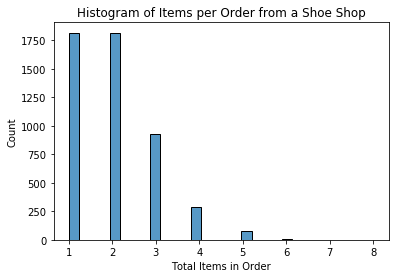

In [9]:
df = df[(df["total_items"] <2000) & (df["shop_id"] != 78)]
print("Max number of items in an order (excluding orders with over 2000 items):")
print(max(df["total_items"]))
sns.histplot(df["total_items"])
plt.title('Histogram of Items per Order from a Shoe Shop')
plt.xlabel("Total Items in Order");

We see that after 2, the frequency of orders decreases as the total items in an order increase. Our max `total_items` of 8 here seems fine in that context - no need to exclude such orders in our AOV calculation. 

Our filtered dataframe now appears suitable to calculate AOV using a simple mean.

In [10]:
print(f"AOV: ${round(df.order_amount.mean(),2)}")

AOV: $302.58


### b)  What metric would you report for this dataset?

After the preprocessing work done in part a), AOV using a mean as done above seems like a reasonable metric to report. 

Another metric that wouldn't require the filtration taken above is the Median Order Value (MOV). Median is a statistic that won't be skewed by outliers since it depends on the rank of order amounts as opposed to taking all amounts directly into its calculation as a mean does.

The question doesn't provide context that would tell us which metric would be favourable, but assuming this metric is on a dashboard and there isn't a good way to apply filtration rules as done in this notebook, the median would be a more consistent metric. Still, the filtration rules applied are very straghtforward, so AOV would be a viable metric in most cases.

Let's take a quick look at the MOV to see how much it differs from AOV.

In [11]:
print(f"Median of filtered dataset: {df.order_amount.median()}\n")

original_df = pd.read_csv("DS_W19_challenge_data.csv",index_col='order_id')

print(f"Median of original dataset: {original_df.order_amount.median()}")

Median of filtered dataset: 284.0

Median of original dataset: 284.0


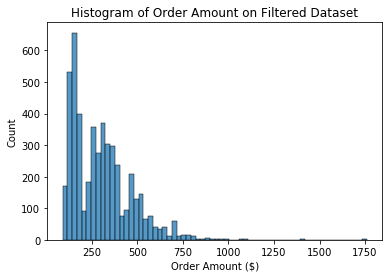

In [12]:
sns.histplot(df["order_amount"])
plt.title('Histogram of Order Amount on Filtered Dataset')
plt.xlabel("Order Amount ($)");

Since the order amount is right-skewed (has positive skewness), we note AOV is above MOV. The question lacks context on exactly why we wanted AOV in the first place, but it's fair to say both metrics give us information of how much a customer spends at shoe shops. 

If looking at the order amount of the average customer, MOV would be more appropriate. If looking at how much, on average, a customer spends in an order, AOV would be more appropriate. 

Both have their own utility and are similar in many respects, but I would choose MOV if we needed a consistent metric resiliant to new outliers that might arise in the data.

### c) What is its value?

MOV has value \$284.00 for the given data.

(AOV on the filtered data has a value of \$302.58)